# Integer Quadratic Programming

Primal problem:
* `minimize` $\sum_{t=1}^{m}k_t\left(k_t-x_t\right)^2 + \rho\sum_{i=1}^{n}\sum_{j=1}^{q}\chi_{(i, j)}$

subject to constraints:
1. $\frac{\alpha_t}{n} \le x_t \le \alpha_t,$ $\forall t=1,2, \dots, m$
2. $x_t \in \left[0, k_t\right],$ $\forall t = 1, 2, \dots, m$
3. $\sum_{j=1}^{q}\chi_{(i, j)} \le 1,$ $\forall i = 1, 2, \dots, n$
4. $\chi_{(i, j)} \in \{0, 1\},$ $\forall i=1, 2, \dots, n,$ $\forall j=1,2, \dots, q$

We have $m+nq$ variables and $2m+n+nq$ constraints

**IQP**

\begin{split}\begin{array}{ll}
\mbox{minimize}   & x^T Q x + q^T x + r \\
\mbox{subject to} & x \in \mathcal{C}\\
& x \in \mathbf{Z}^n,
\end{array}\end{split}


$\mathcal{C}$ is convex set


$\DeclareMathOperator{\diag}{diag}$
Denote:
* $\mathbf{k} = \left(k_1\sqrt{k_1}, k_2\sqrt{k_2}, \dots,k_m\sqrt{k_m}, 0, \dots, 0\right)$
* $\mathbf{d} = \left(0, \dots, 0, \rho, \dots, \rho\right)$
* $\mathbf{x} = \left(x_1, x_2, \dots, x_l\right)$
* $\mathbf{A} = \diag(\sqrt{k_1}, \sqrt{k_2}, \dots, \sqrt{k_m}, 0, \dots, 0)$

With $l=$ len_var
The first term in primal problem $\Leftrightarrow$

`minimize` $||\mathbf{A}\mathbf{x} - \mathbf{k}||_2^2 + \mathbf{d}^T\mathbf{x}$

$||\mathbf{A}\mathbf{x} - \mathbf{k}||_2^2 + \mathbf{d}^T\mathbf{x} = \left(\mathbf{A}\mathbf{x} - \mathbf{k}\right)^T\left(\mathbf{A}\mathbf{x} - \mathbf{k}\right) + \mathbf{d}^T\mathbf{x}
=\mathbf{x}^T\mathbf{A}^T\mathbf{A}\mathbf{x} + \left(\mathbf{d}-2\mathbf{k}\right)^T\mathbf{x}+\mathbf{k}^T\mathbf{k}$

Identity:
* $\mathbf{Q} = \diag(k_1, k_2, \dots, k_m, 0, \dots, 0)$
* $\mathbf{p} = \mathbf{d} - 2\mathbf{A}^T\mathbf{k}$
* $r = \mathbf{k}^T\mathbf{k}$

# Implementation

In [1]:
!pip install xpress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 MB 6.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import cvxpy as cp
import xpress
from matplotlib import pyplot as plt
from matplotlib import patches as ptc
import json
import tqdm
import pickle

In [3]:
!gdown 1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
!gdown 1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE

Downloading...
From: https://drive.google.com/uc?id=1jF6VzCJsvVRwiuh1yMYCDxAQGtFISrcm
To: /content/fix_targets.pkl
100% 4.21M/4.21M [00:00<00:00, 257MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kXT0P1_qKC2VNRf-QLF0lh0AGtT0otzE
To: /content/fix_sensors.pkl
100% 4.45M/4.45M [00:00<00:00, 186MB/s]


## Prepare data

In [4]:
with open("/content/fix_sensors.pkl", 'rb') as f:
  fs_data = pickle.load(f)

with open("/content/fix_targets.pkl", 'rb') as f:
  ft_data = pickle.load(f)


## Utils

In [5]:
def make_pan_boundaries(centroid, q, radius):
    # first line always lies on x_axis
    ans = []
    theta = 2*np.pi/q
    for i in range(q):
        x = radius*np.cos(theta*i)
        y = radius*np.sin(theta*i)
        ans.append((centroid[0] + x, centroid[1] + y))

    return ans

In [6]:
def show_network(data, sensors_mask=None, figsize=None):
    if figsize is not None:
      plt.figure(figsize=(figsize, figsize))

    x_lim = data['margin'][0]
    y_lim = data['margin'][1]

    targets = data['targets']
    sensors = data['sensors']
    radius = data['radius']
    tar_x = [i[0] for i in targets]
    tar_y = [i[1] for i in targets]
    plt.plot(tar_x, tar_y, 'r^', label='targets')
    sen_x = [i[0] for i in sensors]
    sen_y = [i[1] for i in sensors]
    plt.plot(sen_x, sen_y, 'go', label='sensors')
    ax = plt.gca()

    for i in range(len(sensors)):
        sensor = sensors[i]
        active = True

        if sensors_mask is not None:
            active = False
            theta = 360.0/q
            for j in range(q):
                if sensors_mask[q*i+j] == 1:
                    active = True
                    theta1, theta2 = theta*j, theta*(j+1)
                    wedge = ptc.Wedge(sensors[i], radius, theta1, theta2, color='#34e1eb', alpha=0.45)
                    ax.add_artist(wedge)
        if active:
          circle = plt.Circle(sensor, radius, color='m', fill=False, linewidth=1)
          ax.add_artist(circle)
          pan_boundaries = make_pan_boundaries(sensor, data['q'], radius)
          for point in pan_boundaries:
              plt.plot([sensor[0], point[0]], [sensor[1], point[1]], 'b--', alpha=0.2)

    plt.xlim([x_lim[0], x_lim[1]])
    plt.ylim([y_lim[0], y_lim[1]])
    ax.set_aspect(1.0)  # make aspect ratio square

    plt.legend()

    plt.show()

In [7]:
def is_within_FoV(bisector, target, sensor, radius):
    target = np.asarray(target)
    sensor = np.asarray(sensor)
    bisector = np.asarray(bisector)
    v = target - sensor
    dist = np.linalg.norm(v)
    scalar = bisector.dot(v)
    return scalar + 1e-7 >= radius*dist*np.cos(np.pi/8) and dist - 1e-7 <= radius

def init_Gt(m, n, q, radius, targets, sensors):
    Gt = np.zeros((m, n*q))
    bisectors = []
    for i in range(8):
        bisectors.append((radius*np.cos(np.pi/8+i*np.pi/4), radius*np.sin(np.pi/8+i*np.pi/4)))

    for i in range(m):
        for j in range(n):
            for k in range(q):
                Gt[i, q*j+k] = is_within_FoV(bisectors[k], targets[i], sensors[j], radius)
    return Gt


## Represent input

In [ ]:
sample = data['fixed-sensor']['small'][20]

# initialize m, n, q
m = sample['m']    # number of targets
n = sample['n']    # number of sensors
q = sample['q']    # number of pans
targets = sample['targets']
sensors = sample['sensors']
radius = sample['radius']
K = np.asarray(sample['K'])
len_var = m + n*q
rho = 0.0001
print(f'{len_var} variables')

263 variables


In [ ]:
# initialize constants
Gt = init_Gt(m,n, q, radius, targets, sensors)

In [ ]:
# check Gt
for i in range(m):
    print(f'Target {i} with pos {targets[i]} tracked by:')

    for j in range(n):
            for k in range(q):
                if Gt[i, q*j+k] == 1:
                    print(f'\tSensor {j} with pos {sensors[j]} at pan {k}')


Target 0 with pos [97.96505653 68.1012791 ] tracked by:
	Sensor 15 with pos [86.43424947 71.70493744] at pan 7
Target 1 with pos [29.05565175 96.51065734] tracked by:
	Sensor 19 with pos [ 9.49383767 99.32713833] at pan 7
Target 2 with pos [108.38437047 190.07070465] tracked by:
Target 3 with pos [100.09948743 128.07330327] tracked by:
Target 4 with pos [ 94.02308933 188.91126055] tracked by:
Target 5 with pos [  5.23945575 151.95956063] tracked by:
Target 6 with pos [105.59621639 142.93184708] tracked by:
	Sensor 25 with pos [119.08475963 138.84226313] at pan 3
Target 7 with pos [130.27782617 107.89721626] tracked by:
	Sensor 8 with pos [132.7704554  88.9634074] at pan 2
	Sensor 28 with pos [146.88023708 118.6594004 ] at pan 4
Target 8 with pos [ 36.5716321  138.12760674] tracked by:
	Sensor 5 with pos [ 38.8006496  148.59821205] at pan 5
Target 9 with pos [177.4059091  148.49958228] tracked by:
	Sensor 14 with pos [165.07776754 147.14745463] at pan 0
Target 10 with pos [73.31607442 9

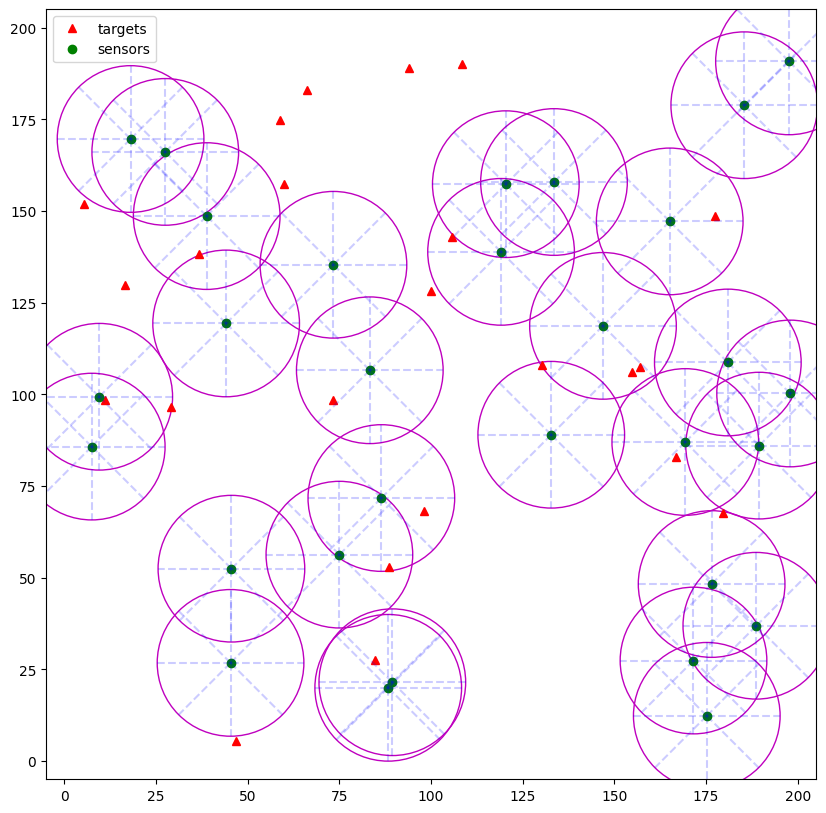

In [ ]:
show_network(sample, figsize=10)

## Make function for solving PIQP

In [9]:
def solve_PIQP(network):
  m = network['m']    # number of targets
  n = network['n']    # number of sensors
  q = network['q']    # number of pans
  targets = network['targets']
  sensors = network['sensors']
  radius = network['radius']
  K = np.asarray(network['K'])
  len_var = m + n*q
  rho = 0.0001
  Gt = init_Gt(m, n, q, radius, targets, sensors)

  # coefficients
  Q = np.zeros((len_var, len_var))
  for i in range(m):
      Q[i, i] = K[i]

  p = np.zeros((len_var,))
  p[0:m] = -2*K*K
  p[m:] = rho*np.ones((n*q,))

  r = (K*K).dot(K)

  # constraints
  # constraint 1
  A1 = np.zeros((m, len_var))
  for i in range(m):
      A1[i, i] = 1
      A1[i, m:] = -Gt[i]
  lower_bound_1 = np.full((m,), -np.inf)
  upper_bound_1 = np.zeros((m,))

  # constraint 2
  A2 = np.zeros((m, len_var))
  for i in range(m):
      A2[i, i] = 1
      A2[i, m:] = -Gt[i]/m
  lower_bound_2 = np.zeros((m,))
  upper_bound_2 = np.full((m,), np.inf)

  # constraint 3
  A3 = np.zeros((n, len_var))
  for i in range(n):
      A3[i, m+q*i: m+q*i+q] = np.ones((q,))
  lower_bound_3 = np.zeros((n,))
  upper_bound_3 = np.ones((n,))

  # bound
  lower_bound_4 = np.zeros((len_var,))
  upper_bound_4 = np.concatenate((K, np.ones((n*q,))))

  # model
  x = cp.Variable(len_var, integer=True)
  objective_func = x.T @ Q @ x + p.T @ x + r
  objective = cp.Minimize(objective_func)

  constraints = [
                A2@x >= lower_bound_2,
                A3@x >= lower_bound_3,
                A3@x <= upper_bound_3,
      A1@x <= upper_bound_1,

                x >= lower_bound_4,
                x <= upper_bound_4]

  prob = cp.Problem(objective, constraints)
  min_value = prob.solve(solver=cp.XPRESS)
  achieved_coverage = x.value[:m]
  sensors_mask = x.value[m:]

  return min_value, achieved_coverage, sensors_mask

## Solve PIQP

In [ ]:
min_value, achieved_coverage, sensors_mask = solve_PIQP(sample)
min_value

177.00140000000002

## Result

In [ ]:
# get achieved coverage
achieved_coverage

array([ 0.,  1., -0., -0., -0., -0.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
        2.,  1.,  2.,  1., -0., -0.,  1., -0., -0., -0.])

In [ ]:
sample['K']

[2, 1, 3, 2, 2, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1, 2, 2, 3]

In [ ]:
# get sensor mask
sensors_mask

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  1.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0.,  1., -0., -0., -0., -0., -0.,  1., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.,  1.,  0., -0., -0.,
       -0., -0., -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0

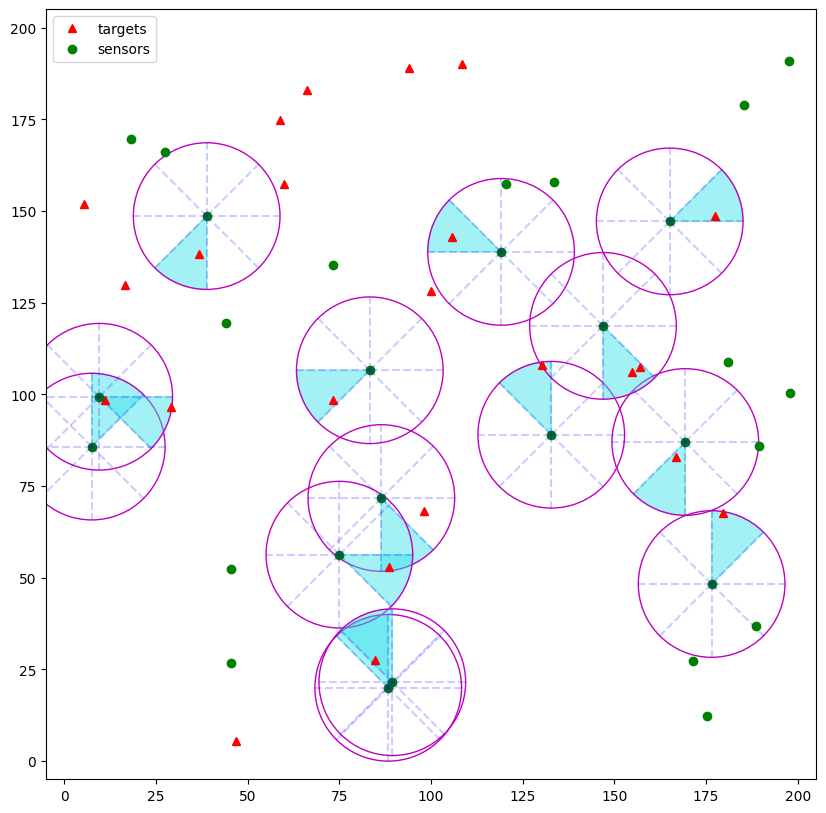

In [ ]:
show_network(sample, sensors_mask, figsize=10)

# Metrics

## Distance index

In [ ]:
def distance_index(k, x):
  a = np.sum(k*k)
  b = k - x
  b = np.sum(b*b)
  return 1 -b/a

## Variance

In [ ]:
def variance(k, x):
  m = len(x)
  mk = np.zeros_like(x)
  for t in range(m):
    mk[t] = np.sum(k == k[t])
  nu_k = np.zeros_like(x)
  for t in range(m):
    ans = 0
    for i in range(m):
      ans += x[i]*(k[i] == k[t])
    nu_k[t] = ans/mk[t]

  a = (x - nu_k)

  return np.sum(a*a/mk)

## Acivated sensors

In [10]:
def activated_sensors(n_sensors, q, mask):
  cnt = 0
  for i in range(n_sensors):
    for j in range(q):
      if mask[q*i+j] == 1:
        cnt += 1

  return cnt

# Evaluate

## Fixed sensor

### Distance index

In [ ]:
DI_small = []
for i in range(10):
  di = []
  for dt in tqdm.tqdm(fs_data[i]['small']):
    _, achieved_coverage, _ = solve_PIQP(dt)
    DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
    di.append(DI_score)
  DI_small.append(di)

 28%|██▊       | 33/118 [00:06<00:16,  5.25it/s]


ArpackNoConvergence: ignored

In [ ]:
DI_avg = np.mean(DI_small, axis=0)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'PIQP': DI_avg})
df.to_csv(index=False)

df.to_csv('/content/distance_index_fix_sensor.csv')

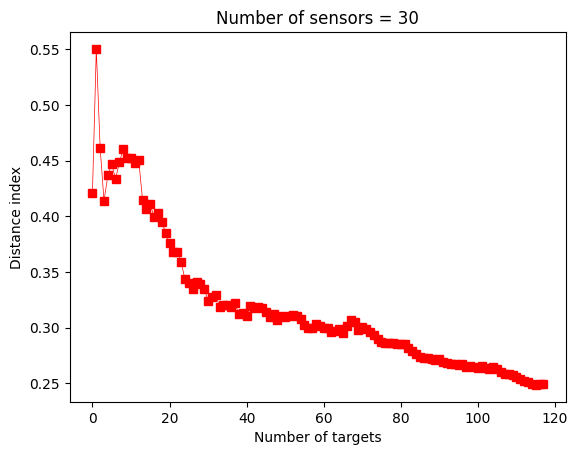

In [ ]:
x_axis = np.arange(len(DI_avg))
plt.plot(x_axis, DI_avg, 'r-', linewidth=0.5)
plt.plot(x_axis, DI_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Distance index")
plt.title('Number of sensors = 30')
plt.show()

### Variance

In [ ]:
VAR_small = []
for i in range(10):
  var = []
  for dt in tqdm.tqdm(fs_data[i]['small']):
    _, achieved_coverage, _ = solve_PIQP(dt)
    var_score = variance(np.asarray(dt['K']), achieved_coverage)
    var.append(var_score)
  VAR_small.append(var)

 19%|█▉        | 23/118 [00:04<00:16,  5.61it/s]


KeyboardInterrupt: ignored

In [ ]:
len(VAR_small)

8

In [ ]:
VAR_avg = np.sum(VAR_small, axis=0)

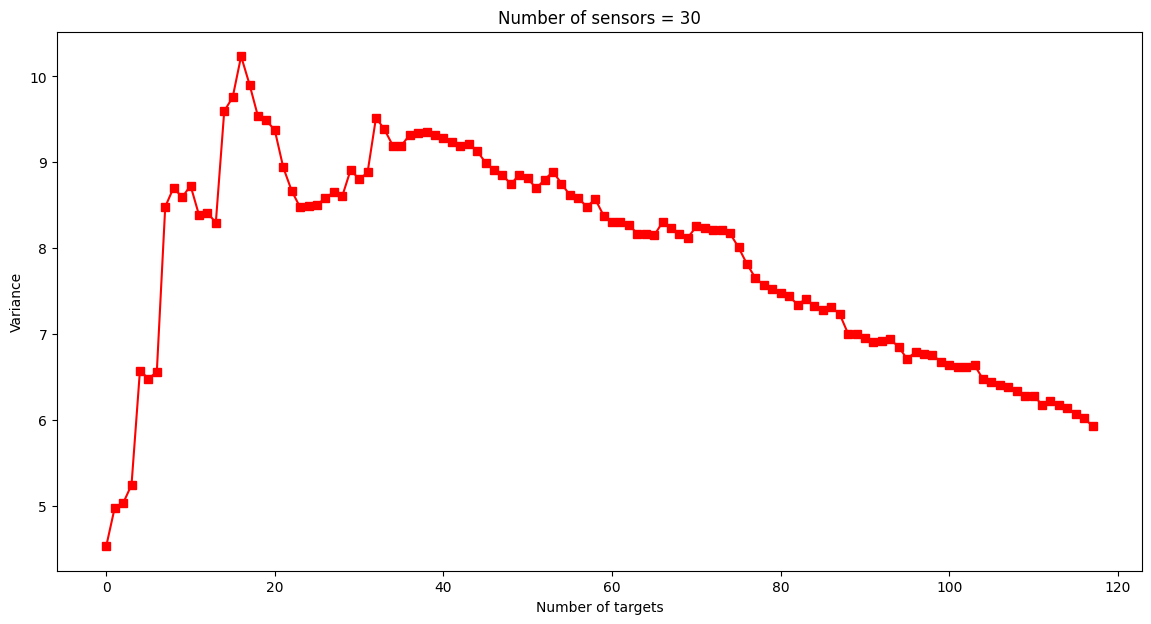

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(VAR_avg))
plt.plot(x_axis, VAR_avg, 'r-')
plt.plot(x_axis, VAR_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.title('Number of sensors = 30')
plt.show()

In [ ]:
df = pd.DataFrame({'PIQP': VAR_avg})
df.to_csv(index=False)

df.to_csv('/content/variance.csv')

### CQ

In [ ]:
def coverage_quality(mask, network):
  sensors = network['sensors']
  targets = network['targets']
  radius = network['radius']
  n = network['n']
  m = network['m']
  q = network['q']
  T = np.zeros((n, q, m), dtype=bool)

  bisectors = []
  for i in range(q):
      bisectors.append((radius*np.cos(np.pi*(1 + i*2)/q), radius*np.sin(np.pi*(1 + i*2)/q)))

  for i in range(n):
      for j in range(m):
          for p in range(q):
              T[i, p, j] = is_within_FoV(bisectors[p], targets[j], sensors[i], radius)

  U = np.zeros((n, q, m), dtype=float)
  for i in range(n):
    for j in range(m):
        for p in range(q):
          if T[i, p, j]:
            target = np.asarray(targets[j])
            sensor = np.asarray(sensors[i])
            v = target - sensor
            U[i, p, j] = 1 - np.square(np.linalg.norm(v)/radius)

  S = np.zeros((n, q), dtype=bool)
  for i in range(n):
    for j in range(q):
      if mask[i*q+j] == 1:
        S[i, j] = True

  return np.sum(np.sum(U, axis=2)*S)

In [ ]:
CQ_fs_small = []
for i in range(10):
  cq = []
  for dt in tqdm.tqdm(fs_data[i]['small']):
    _, achieved_coverage, mask = solve_PIQP(dt)
    cq_sc = coverage_quality(mask, dt)
    cq.append(cq_sc)
  CQ_fs_small.append(cq)

 11%|█         | 13/118 [00:02<00:20,  5.12it/s]


ArpackNoConvergence: ignored

In [ ]:
CQ_fs_avg = np.mean(CQ_fs_small, axis=0)

In [ ]:
df = pd.DataFrame({'PIQP': CQ_fs_avg})
df.to_csv(index=False)

df.to_csv('/content/CQ_fix_sensor.csv')

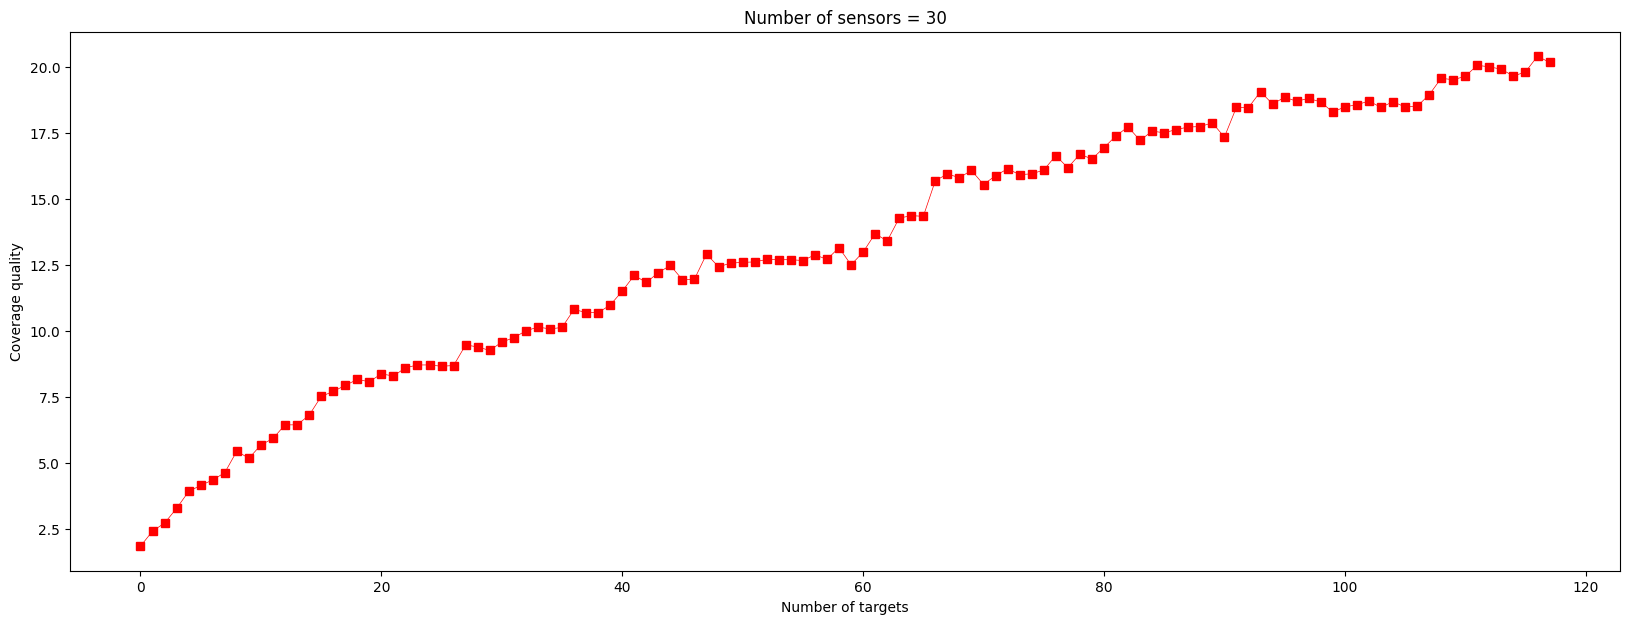

In [ ]:
plt.figure(figsize=(20, 7))
x_axis = np.arange(len(CQ_fs_avg))
plt.plot(x_axis, CQ_fs_avg, 'r-', linewidth=0.5)
plt.plot(x_axis, CQ_fs_avg, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Coverage quality")
plt.title(f'Number of sensors = 30')
plt.show()

In [11]:
index = range(0, 118, 3)

In [13]:
ACT_fs = []
for i in range(10):
  act_fs = []
  for id in tqdm.tqdm(index):
    dt = fs_data[i]['small'][id]
    _, achieved_coverage, mask = solve_PIQP(dt)
    # var_score = variance(np.asarray(dt['K']), achieved_coverage)
    act_score = activated_sensors(dt['n'], dt['q'], mask)

    act_fs.append(act_score)

  ACT_fs.append(act_fs)

100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


In [14]:
ACT_fs_avg_piqp = np.mean(ACT_fs, axis=0)

In [18]:
with open("/content/act_fs_piqp.npy", "wb") as f:
  np.save(f, ACT_fs_avg_piqp)

## Fixed target

### Distance index

In [ ]:
DI_small = []
for i in range(10):
  di = []
  for dt in tqdm.tqdm(ft_data[i]['small']):
    _, achieved_coverage, _ = solve_PIQP(dt)
    DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
    di.append(DI_score)
  DI_small.append(di)


100%|██████████| 118/118 [00:42<00:00,  2.76it/s]


In [ ]:
DI_avg = np.mean(DI_small, axis=0)

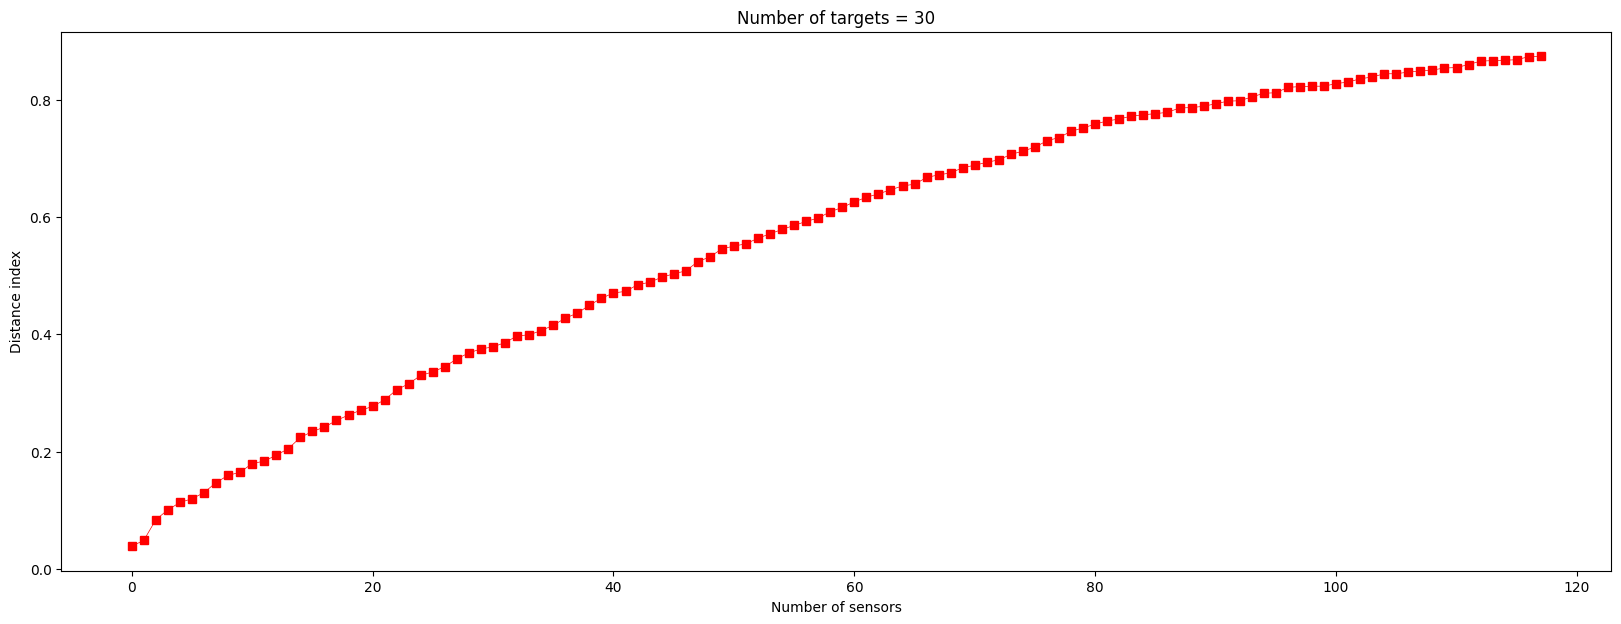

In [ ]:
plt.figure(figsize=(20, 7))
x_axis = np.arange(len(DI_avg))
plt.plot(x_axis, DI_avg, 'r-', linewidth=0.5)
plt.plot(x_axis, DI_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Distance index")
plt.title(f'Number of targets = 30')
plt.show()

In [ ]:
df = pd.DataFrame({'PIQP': DI_avg})
df.to_csv(index=False)

df.to_csv('/content/distance_index_fix_target.csv')

### Variance

In [ ]:
VAR_ft = []
ACT_ft = []
for i in range(10):
  var_ft = []
  act_ft = []
  for dt in tqdm.tqdm(ft_data[i]['small']):
    _, achieved_coverage, mask = solve_PIQP(dt)
    var_score = variance(np.asarray(dt['K']), achieved_coverage)
    act_score = activated_sensors(dt['n'], dt['q'], mask)
    var_ft.append(var_score)
    act_ft.append(act_score)
  VAR_ft.append(var_ft)
  ACT_ft.append(act_ft)


 25%|██▍       | 29/118 [00:05<00:16,  5.42it/s]


ArpackNoConvergence: ignored

In [ ]:
VAR_ft_avg = np.mean(VAR_ft, axis=0)
ACT_ft_avg = np.mean(ACT_ft, axis=0)

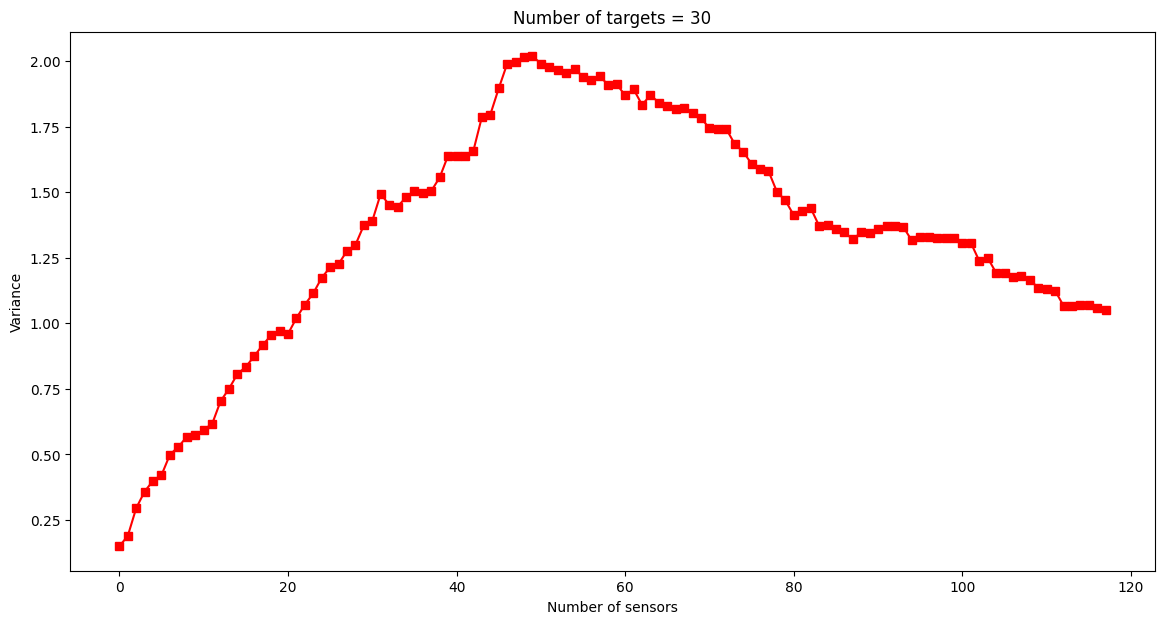

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(VAR_ft_avg))
plt.plot(x_axis, VAR_ft_avg, 'r-')
plt.plot(x_axis, VAR_ft_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Variance")
plt.title(f'Number of targets = {30}')
plt.show()

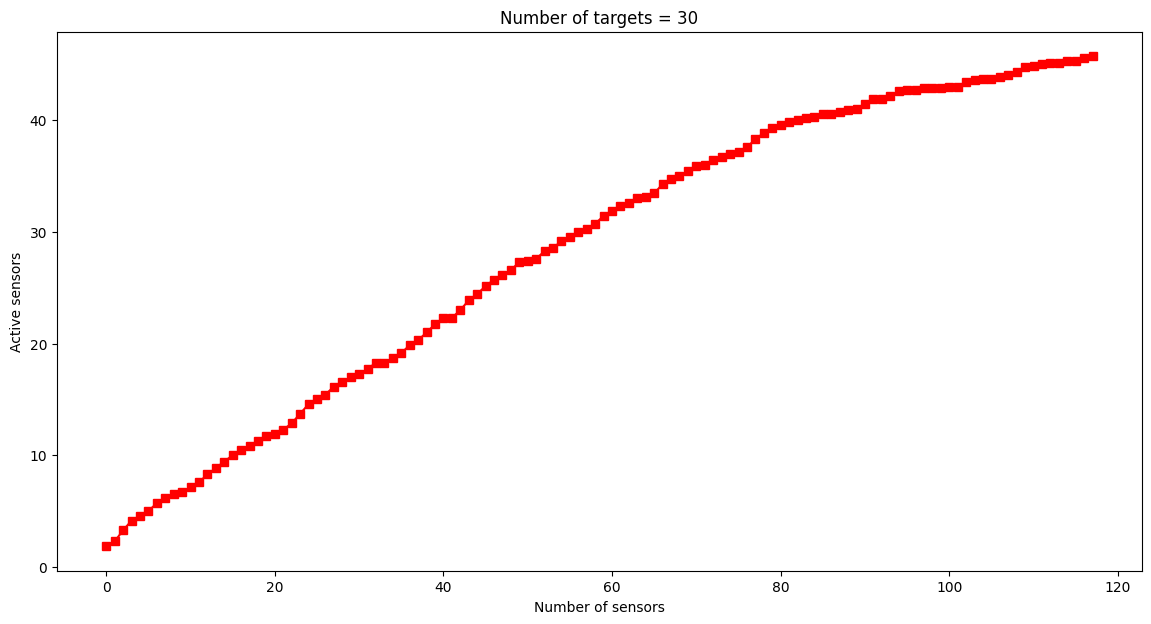

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(ACT_ft_avg))
plt.plot(x_axis, ACT_ft_avg, 'r-')
plt.plot(x_axis, ACT_ft_avg, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Active sensors")
plt.title(f'Number of targets = {30}')
plt.show()

In [ ]:
df = pd.DataFrame({'PIQP': VAR_ft_avg})
df.to_csv(index=False)

df.to_csv('/content/variance_fix_target.csv')

In [ ]:
df = pd.DataFrame({'PIQP': ACT_ft_avg})
df.to_csv(index=False)

df.to_csv('/content/active_fix_target.csv')

In [ ]:
CQ_ft_small = []
for i in range(10):
  cq = []
  for dt in tqdm.tqdm(ft_data[i]['small']):
    _, achieved_coverage, mask = solve_PIQP(dt)
    cq_sc = coverage_quality(mask, dt)
    cq.append(cq_sc)
  CQ_ft_small.append(cq)

 42%|████▏     | 49/118 [00:15<00:21,  3.20it/s]


ArpackNoConvergence: ignored

In [ ]:
CQ_ft_avg = np.mean(CQ_ft_small, axis=0)

In [ ]:
df = pd.DataFrame({'PIQP': CQ_ft_avg})
df.to_csv(index=False)

df.to_csv('/content/cq_ft.csv')